# Bayesian Optimal Pricing

This notebook demonstrates the development of an optimal pricing strategy using a bayesian inference model. 

In this example we have collected sales data for units of goods sold $Q$ at several price points $P$. The general assumption of this excercise for that consumer demand, appetite to purchase goods, to be conditional on the product price. In economis this is known as the price elasticity of demand [[wiki](https://en.wikipedia.org/wiki/Price_elasticity_of_demand)].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Here are the data for units of good sold at difference price points.

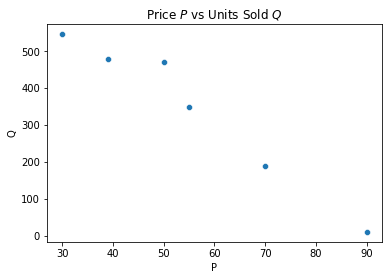

In [2]:
q = [546, 480, 470, 350, 190, 10]
p = [30, 39, 50, 55, 70,90]

df = pd.DataFrame({'P':p,'Q':q})
sns.scatterplot(data=df,x='P',y='Q',)
plt.title('Price $P$ vs Units Sold $Q$');

#### Mathematical model
The relationship between the quantity of units solds $Q$ and the price charged $P$ can be formalised as a deterministic function:
$$Q= aP^c$$

Probabilistically, we can think of $Q$ unit sales as independent purchase events following a poison distribution. Furthermore, that the rate of sales is conditionally dependant on the unit price $P$:
$$E(Q|P) = aP^c$$


In [3]:
#!conda install pymc3 -y
import pymc3 as pm

formalising this as a model:
- [cauchy priors](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3663.htm) probability for no distribution assumption.

In [4]:
with pm.Model() as m1:
    a = pm.Cauchy('a',0,5)
    c = pm.Cauchy('c',0,5)
    logμ0 = a + c * np.log(p)
    μ0 = pm.Deterministic('μ0',np.exp(logμ0))
    qval = pm.Poisson('q',μ0,observed=q)
m1

sampling form the model and print key summary:

 - mc_error estimates simulation error by breaking the trace into batches, computing the mean of each batch, and then the standard deviation of these means.
 - hpd_* gives highest posterior density intervals. The 2.5 and 97.5 labels are a bit misleading. There are lots of 95% credible intevals, depending on the relative weights of the left and right tails. The 95% HPD interval is the narrowest among these 95% intervals.
 - Rhat is sometimes called the potential scale reduction factor, and gives us a factor by which the variance might be reduced, if our MCMC chains had been longer. It's computed in terms of the variance between chains vs within each chain. Values near 1 are good.


In [5]:
with m1:
    trace = pm.sample(draws=1500)
summary = pm.summary(trace)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:08<00:00, 918.15draws/s] 
The acceptance probability does not match the target. It is 0.8939171719654615, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846029291935292, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9179401262151454, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,11.632,0.252,11.155,12.101,0.009,0.006,784.0,784.0,799.0,707.0,1.0
c,-1.503,0.067,-1.628,-1.377,0.002,0.002,780.0,780.0,793.0,710.0,1.0
μ0[0],679.220,22.590,636.471,721.386,0.622,0.440,1319.0,1319.0,1324.0,1754.0,1.0
μ0[1],457.769,10.821,438.652,479.260,0.181,0.128,3593.0,3593.0,3579.0,4050.0,1.0
μ0[2],315.127,7.731,301.518,330.315,0.140,0.099,3069.0,3069.0,3061.0,4302.0,1.0
μ0[3],273.093,7.544,259.188,287.246,0.177,0.125,1822.0,1820.0,1821.0,3242.0,1.0
μ0[4],190.139,7.438,176.146,203.877,0.225,0.160,1088.0,1085.0,1088.0,1306.0,1.0
μ0[5],130.416,6.997,117.779,144.043,0.231,0.164,918.0,913.0,926.0,1071.0,1.0


In [6]:
# model and trace names
print(m1.basic_RVs,trace.varnames)

[a, c, q] ['a', 'c', 'μ0']


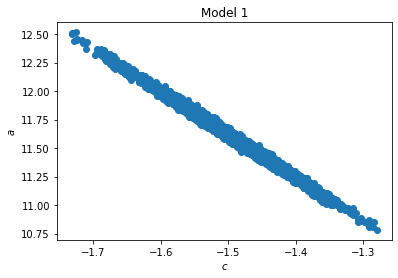

In [7]:
# parameter estimates
plt.title('Model 1')
plt.scatter(trace['c'],trace['a'])
plt.xlabel('$c$')
plt.ylabel('$a$');

#### Reparameterise 
The correlation of the model parameters illustrated above can cause issues in some situations. This is largely due to the positive nature of the price values. To account for this we can center the $P$ values.

In [8]:
# model with log centered quantities
with pm.Model() as m2:
    alpha = pm.Cauchy('alpha',0,5)
    beta = pm.Cauchy('beta',0,5)
    logμ0 = alpha + beta * (np.log(p) - np.log(p).mean())
    μ0 = pm.Deterministic('μ0',np.exp(logμ0))
    qval = pm.Poisson('q0',μ0,observed=q)
m2

In [9]:
# sample model 2
with m2:
    trace2 = pm.sample(draws=1500)
summary2 = pm.summary(trace2)
summary2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2608.95draws/s]
The acceptance probability does not match the target. It is 0.8886979711163342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029781770355928, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,5.687,0.025,5.638,5.731,0.000,0.000,3063.0,3063.0,3067.0,3189.0,1.0
beta,-1.507,0.066,-1.632,-1.383,0.001,0.001,3039.0,3028.0,3035.0,3312.0,1.0
μ0[0],680.548,22.345,637.886,720.894,0.321,0.228,4839.0,4810.0,4866.0,3856.0,1.0
μ0[1],458.221,10.530,439.872,479.019,0.149,0.105,5019.0,5000.0,5027.0,3882.0,1.0
μ0[2],315.148,7.494,301.145,328.908,0.132,0.093,3245.0,3240.0,3252.0,3417.0,1.0
μ0[3],273.016,7.346,258.770,285.967,0.136,0.096,2905.0,2903.0,2910.0,3038.0,1.0
μ0[4],189.916,7.310,175.748,202.786,0.142,0.100,2664.0,2664.0,2659.0,3034.0,1.0
μ0[5],130.141,6.907,117.264,143.084,0.134,0.094,2673.0,2673.0,2663.0,2944.0,1.0


In [10]:
# model and trace vars
print(m2.basic_RVs,trace2.varnames)

[alpha, beta, q0] ['alpha', 'beta', 'μ0']


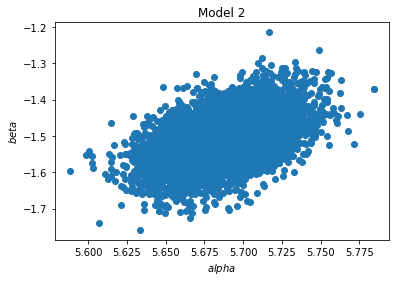

In [11]:
# parameter estimates
plt.title('Model 2')
plt.scatter(trace2['alpha'],trace2['beta'])
plt.xlabel('$alpha$')
plt.ylabel('$beta$');

Below are PyMC3 traceplots. Sampling is done using an independent (Markov) chain for each hardware core (default). 

The left column shows distributions across markoc Chain simulaitons of each core. 
The right column shows the auto-correlation of alpha and beta parameters in each iteration. 

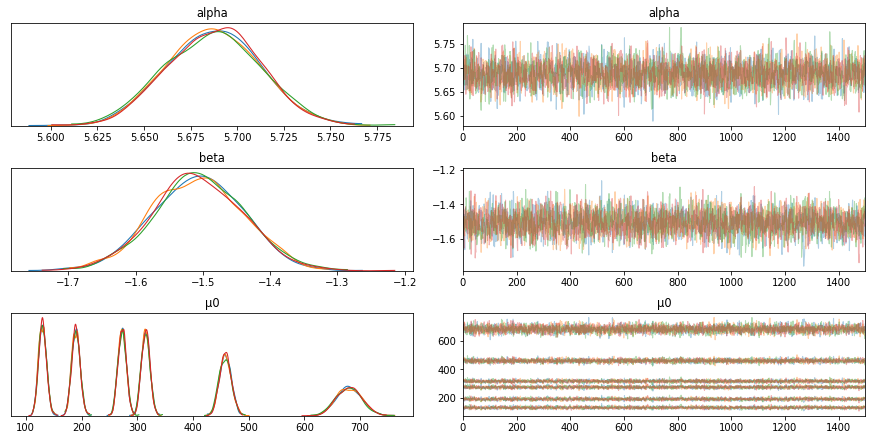

In [12]:
# note there are a few user warnings on using pymc3.traceplot() with pyplot
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.traceplot(trace2);

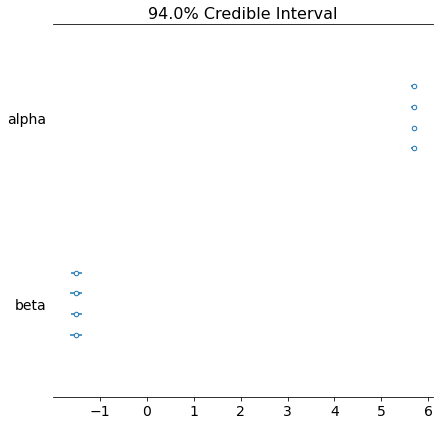

In [13]:
pm.forestplot(trace2,var_names=['alpha','beta']);

### Posterior Predictions

In **plot 1** each "hair" represents $E[Q∣P]$ according to one sample from the predicted posterior.

**Plot 2** shows the probability of observing a smaller value of $Qpred$ than what was actually observed $Qobs$ at each price $P$, formally: $$P(Qpred < Qobs|P$$

The plot is constructed by aggregating predcted posterior values at each price point. For instance we observed 600 units sold at a price of 30 and a very low predicted probability of seeing less than 600 units being sold. Some 470 units were sold at a price of 50 and this has a higher probability for less than 470 units being sold. 

In [14]:
# observations
df

,P,Q
0,30,546
1,39,480
2,50,470
3,55,350
4,70,190
5,90,10


In [15]:
from scipy import stats

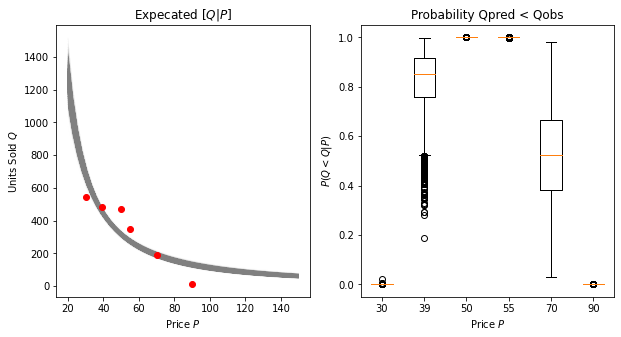

In [16]:
fig,axs = plt.subplots(1,2,figsize=(10,5))

# Expected Q|P
axs[0].set_title('Expecated $[Q|P]$')
pi = np.linspace(20,150)
μ = np.exp(trace2.alpha + trace2.beta * (np.log(pi).reshape(-1,1) - np.log(p).mean()))
axs[0].plot(pi,μ,c='grey',alpha=0.01,linewidth=0.5)
axs[0].plot(p,q,'o',c='red')
axs[0].set_xlabel('Price $P$')
axs[0].set_ylabel('Units Sold $Q$')

# Expectation of Q < Qobs
axs[1].set_title('Probability Qpred < Qobs')
axs[1].boxplot(stats.poisson.cdf(q,mu=trace2['μ0']))
axs[1].set_xticklabels(p)
axs[1].set_xlabel('Price $P$')
axs[1].set_ylabel('$P(Q < Q|P)$');

Bayesian p-values are another common diagnostic metric. These are generated by comparing samples generated using the returned posterior paramters values $Qret$ to observed values $Qobs$.

In [17]:
np.mean(q  > np.random.poisson(trace2['μ0']), 0)

array([1.66666667e-04, 8.16333333e-01, 1.00000000e+00, 1.00000000e+00,
       4.95000000e-01, 0.00000000e+00])

### Price Optimisation

Assuming that the cost of unit production is contant $k$, we can determine the $\mathbf{E}[Q|P]$ that maximises profits.

In [18]:
unit_cost = 10.0 # cost of making each unit
unit_profit = (np.array(pi) - unit_cost).reshape(-1,1) * μ # profit at each price point

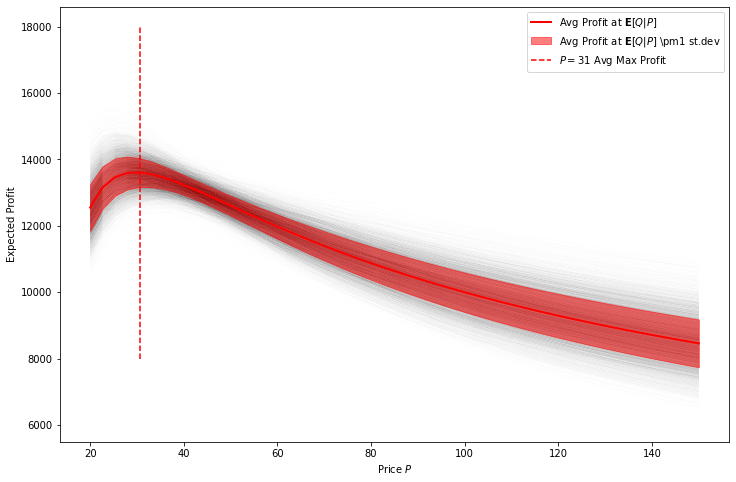

In [19]:
fig,axs = plt.subplots(1,1,figsize=(12,8))

# traces
axs.plot(pi,unit_profit,c='black',lw=0.02,alpha=0.1,zorder=0)

# avg
axs.plot(pi,np.mean(unit_profit,1).T,c='red',lw=2,
         label="Avg Profit at $\mathbf{E}[Q|P]$", zorder=5)

# avg +- 1std
axs.fill_between(pi,
                 (np.mean(unit_profit,1)-np.std(unit_profit,1)).T,
                 (np.mean(unit_profit,1)+np.std(unit_profit,1)).T,
                 label="Avg Profit at $\mathbf{E}[Q|P]$ \pm1 st.dev",
                 alpha=0.5,color='red', zorder=10)

pmax = pi[np.argmax(np.mean(unit_profit,1))]
axs.vlines(pmax,8000,18000,colors='red',linestyles='dashed',label=f"$P=${pmax:.0f} Avg Max Profit")

axs.set_xlabel('Price $P$')
axs.set_ylabel('Expected Profit')
axs.legend();

#### references 
- https://github.com/rmcelreath/statrethinking_winter2019
- https://learningstatisticswithr.com/book/bayes.html
- https://blogs.oracle.com/datascience/introduction-to-bayesian-inference 
- https://www.itl.nist.gov/div898/handbook/eda/section3/eda3663.htm
- https://docs.pymc.io/notebooks/api_quickstart.htmlpm.forestplot(t,varnames=['α','β'])
- https://en.wikipedia.org/wiki/Conditional_independence
- https://opentextbc.ca/principlesofeconomics/chapter/5-1-price-elasticity-of-demand-and-price-elasticity-of-supply/